In [18]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

Given the number of natural disasters for each year from 1851 to 1962. There is an assumption that after some year there has been a significant shift in the number of disasters.
The goal is to find this year.

There is the dataset:

# Dataset

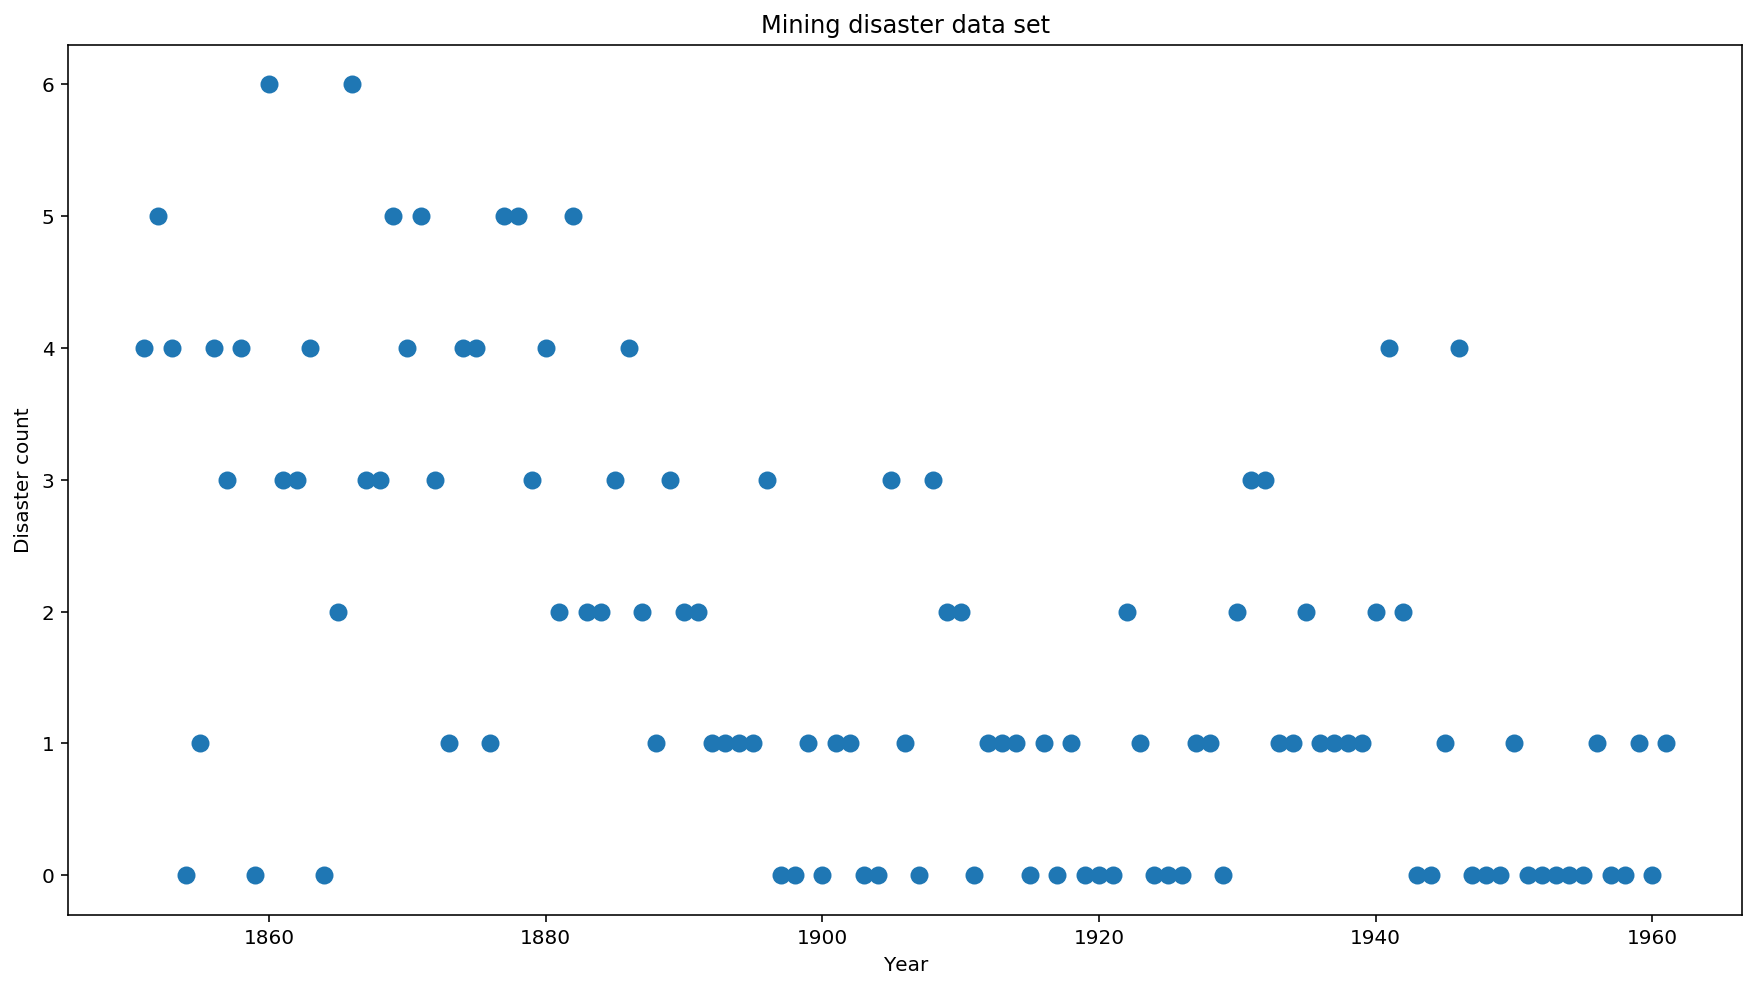

In [19]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

According to the graphic, indeed, some changes happened in about 1890.   

Let's define a model.  
  $p(s|X)$-? where $s$ is the switch point (year), $X$ - observations  
  $p(s|X) = {{p(X|s)p(s)} \over p(X)}$  
  $p(X)$ can be modeled with the Poisson distribution (expresses the probability of a given number of events *disasters* occurring in a fixed interval of time *year*), i.e. $p(X=k)={\lambda^k {e^{-\lambda}} \over {k!}}$

$\lambda$ is unknown, moreover $\lambda$ changes at the switch point $s$:
$\lambda=
  \begin{cases}
    \lambda_e & if & x < s \\
    \lambda_l & if & x \ge s
  \end{cases} 
$

The Exponential distribution (a process in which events occur continuously and independently at a constant average rate) will be used as a prior for $\lambda$ and the Uniform distribution for $s$</br>
![example](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Exponential_probability_density.svg/325px-Exponential_probability_density.svg.png)

Then $p(s, e, l|X) = {{p(X|s, e, l)p(s)p(l)p(e)} \over p(X)}$ ($s,l,e$ are independent)

In [6]:
def disaster_count_model(disaster_rate_fn):
  disaster_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(years)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=disaster_rate_fn(np.arange(len(years)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return disaster_count

def disaster_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l) # returns array [e, e, e,.. l, l,..]. Not differentiable

def disaster_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

`model_switch` is based on a stepwise function for $\lambda$   
`sigmoid` uses a sigmoid switch $\lambda$ (hence differentiable)

Quick check of the models:

1. s=40 (1851 + 40), e=3, l=0.9
2. s=60, e=1, l=5
3. s=-10, e=1, l=1

Note, that if $e=3$ it means that $e=\lambda_e=E(X_<s)=3$ 


In [7]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=disaster_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-176.94559, -176.28717]
[-371.3125, -366.8816]
[-inf, -inf]


Why is log_prob used?

$D_{KL}(P\|Q) = \sum_{x\in X} P(x) \log\left({{P(x)} \over {Q(x)}}\right) = \sum_{x\in X}P(x)\log(P(x))-\sum_{x\in X}P(x)\log(Q(x))$  
$log(Q(x))$ - it is what we provide 

$\sum_{x\in X}P(x)\log(P(x))$ - constant  

i.e the goal is to minimize weighted $log(Q(x|s,e,l))$ via tuning $s,e,l$

Bijectors are needed for inverse transformations to construct PMFs of transformed distribution (**check in the book**)

There is another explanation why Bijectors are used:
*This is not the full story though. If you go back to the model definition above, you’ll note that some of the probability distributions are **not well-defined on the whole real number line**. Therefore we constrain the space that HMC shall examine by wrapping the HMC kernel with a TransformedTransitionKernel that specifies **the forward bijectors to transform the real numbers onto the domain that the probability distribution is defined on (see comments in the code below)**.*

In [8]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       # The order is according to target_log_prob_fn arguments order
       bijector=[ 
          # The switchpoint is constrained between zero and len(years).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          # y - (0;len(yers)), x - (-inf;+inf)
          tfb.Sigmoid(low=0., high=tf.cast(len(years), dtype=tf.float32)),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          # y - (0;+inf), x - (-inf;+inf)
          tfb.Softplus(),
          # y - (0;+inf), x - (-inf;+inf)
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_disaster_rate'),
          tf.ones([], name='init_late_disaster_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

In [9]:
switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, early_disaster_rate, late_disaster_rate = zip(switch_samples, sigmoid_samples)

In [41]:
switchpoint

(array([37.324966, 42.86912 , 40.778328, ..., 39.78493 , 38.835552,
        38.835552], dtype=float32),
 array([41.37328 , 44.48446 , 36.4384  , ..., 40.474327, 40.474327,
        40.474327], dtype=float32))

In [42]:
np.shape(switchpoint)

(2, 10000)

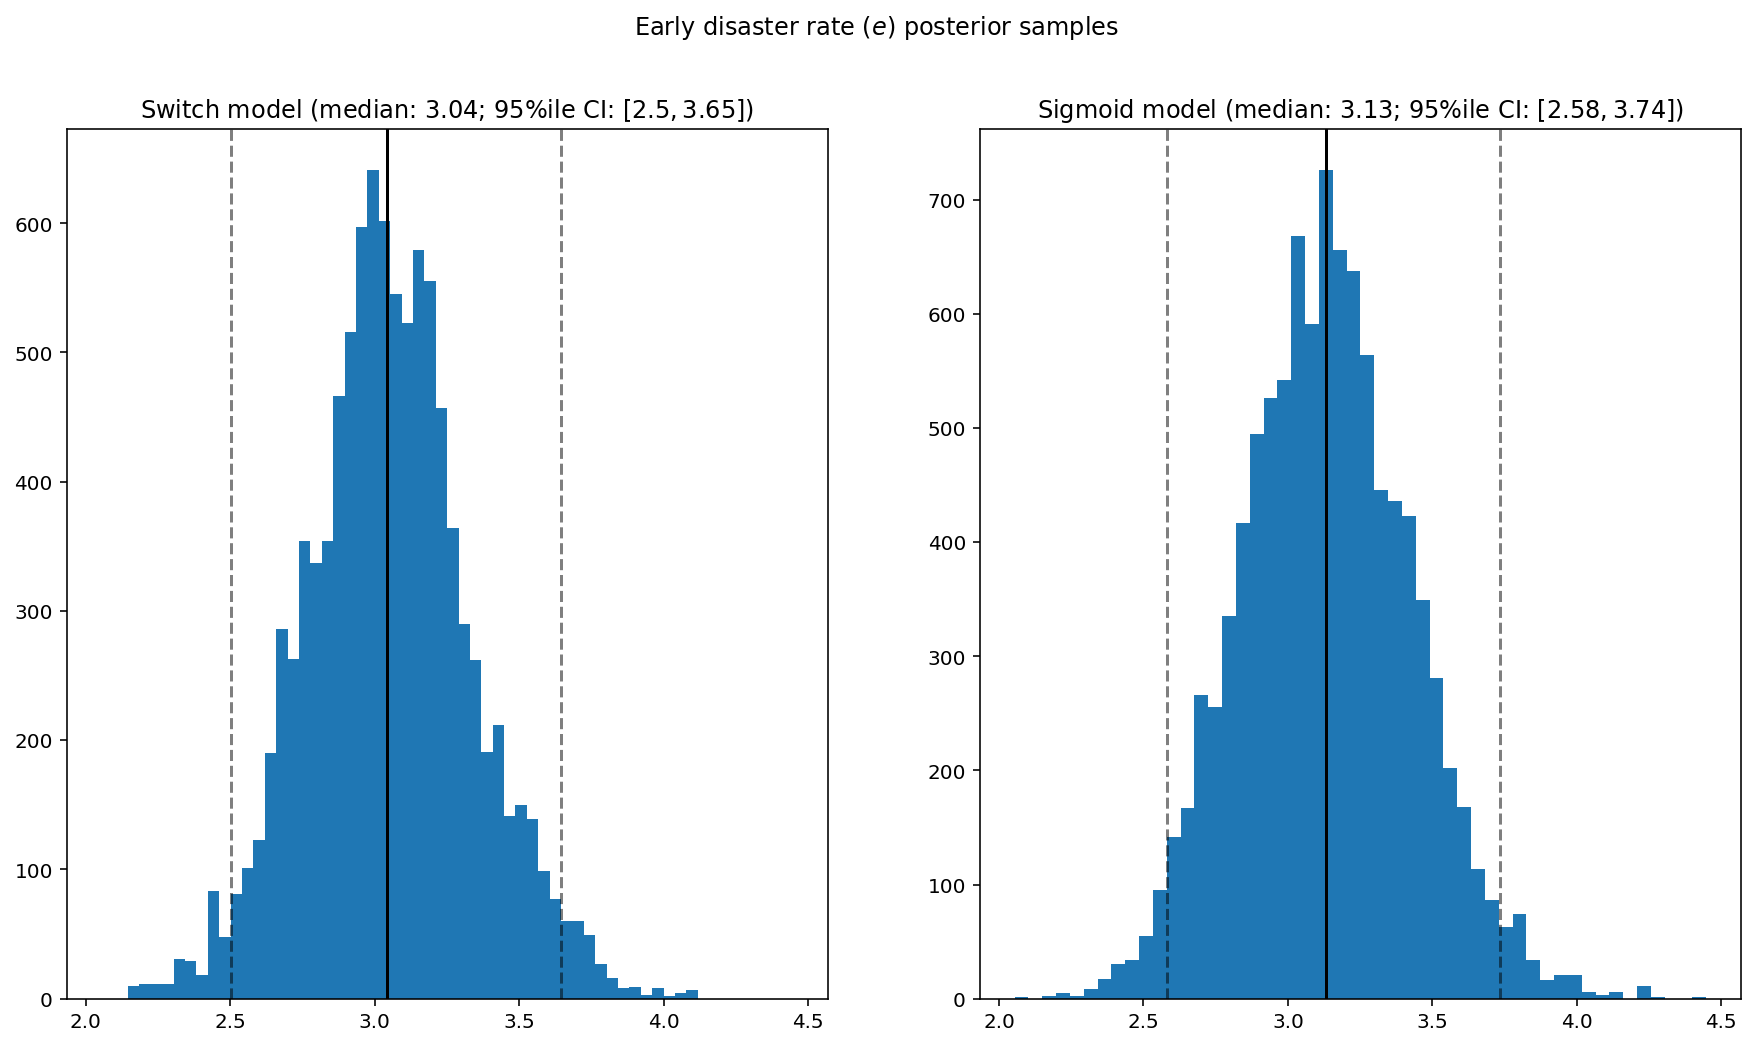

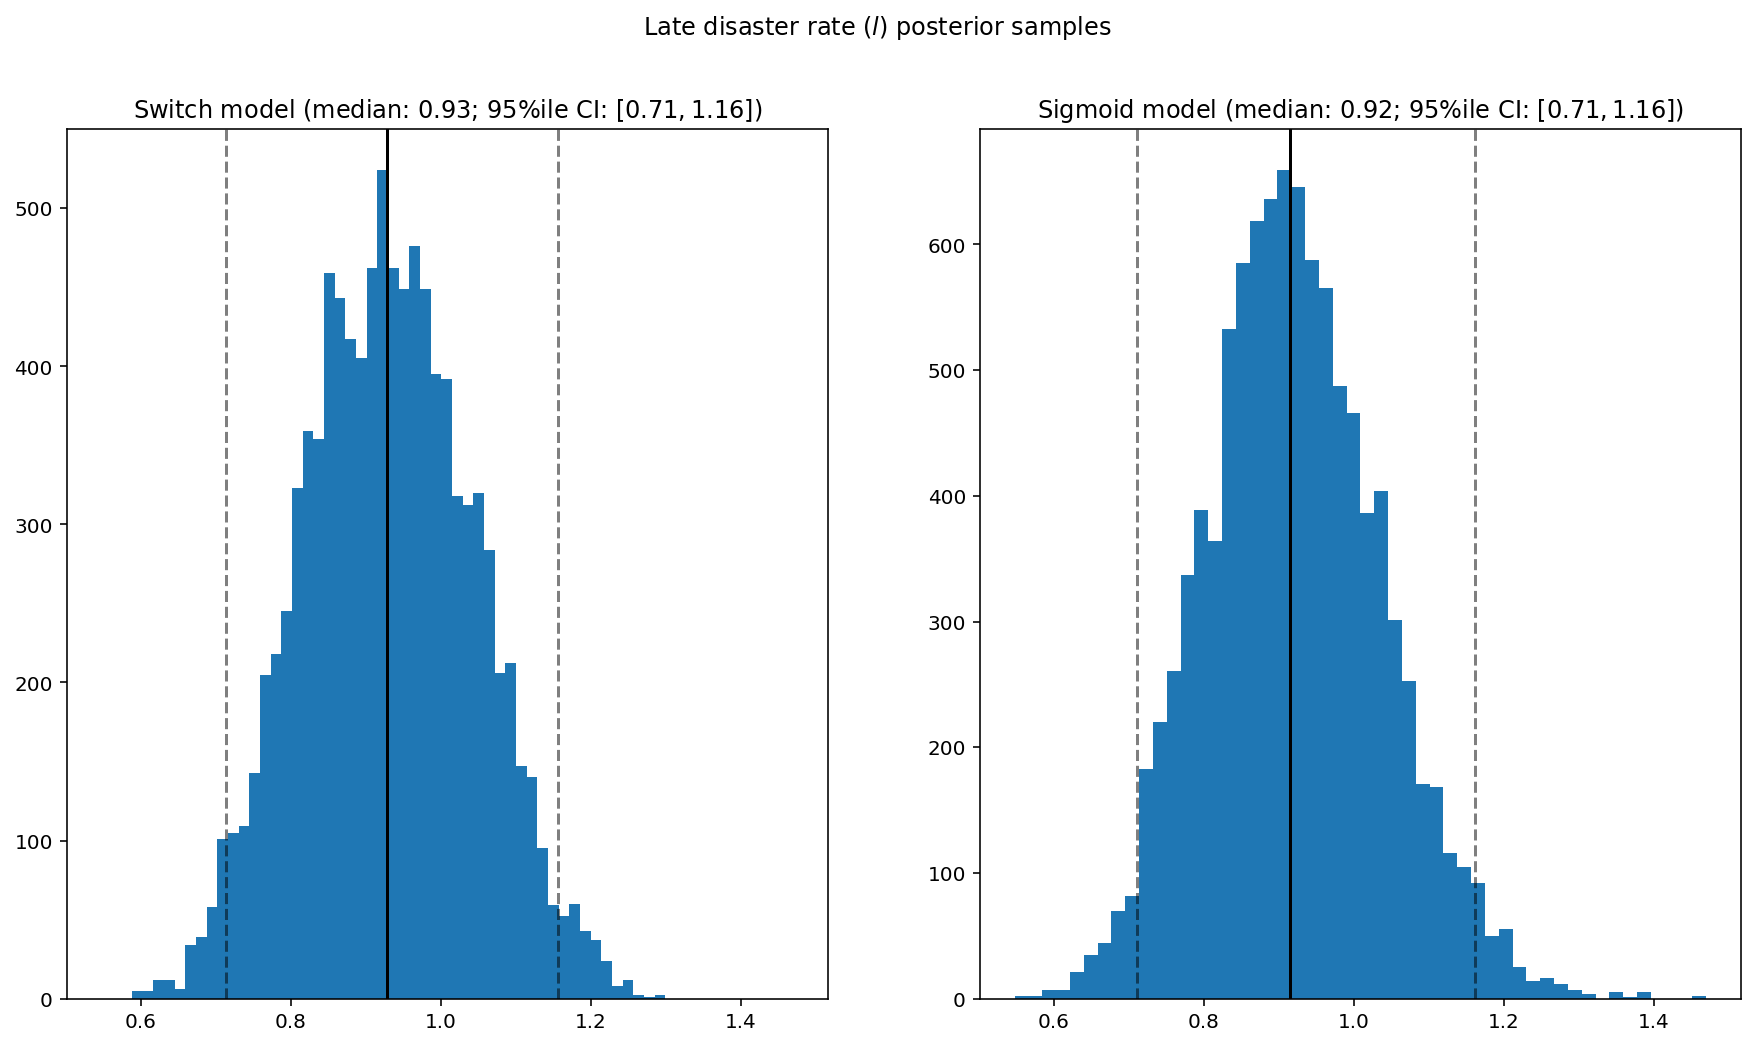

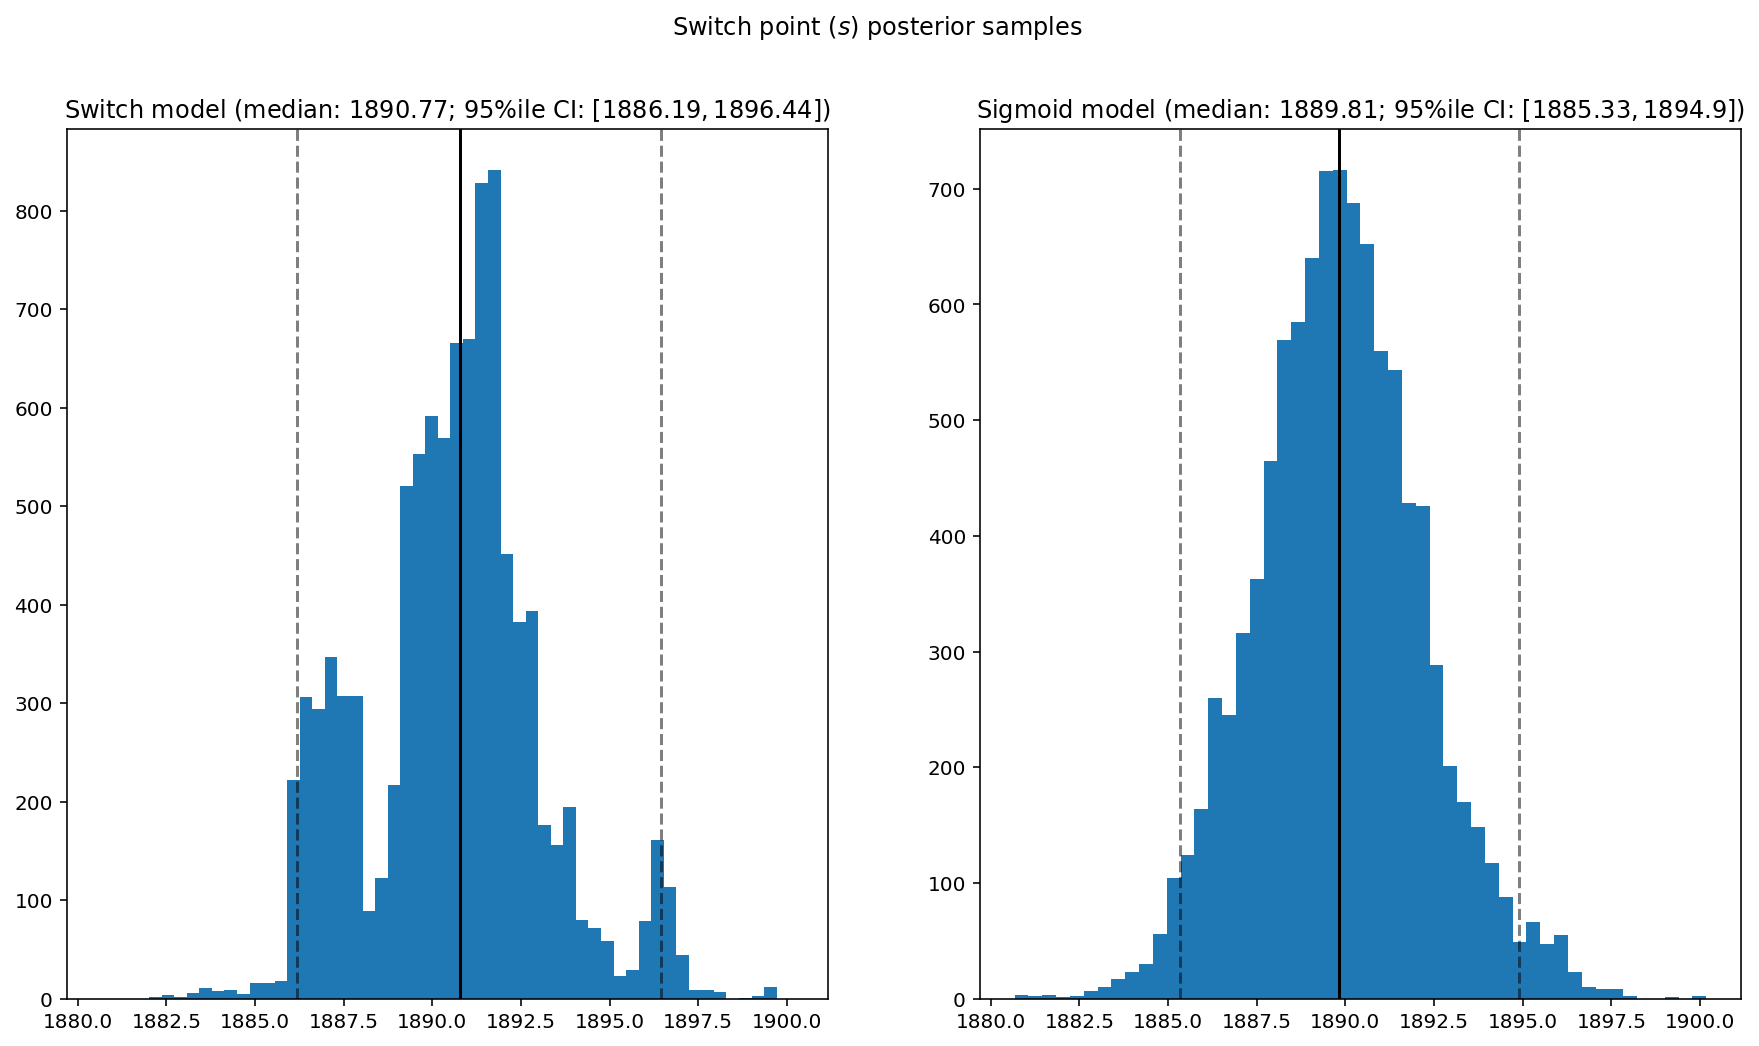

In [17]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(*np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [('Early disaster rate ($e$) posterior samples', early_disaster_rate),
             ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
             ('Switch point ($s$) posterior samples', years[0] + switchpoint)]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()

So, according to posterior 
s = 39 (1890 - 1851)
e = 3.04
l = 0.9


In [33]:
print(target_log_prob_fn(model_switch, 40., 3.04, .93).numpy()) 

-176.9258


In [36]:
print(target_log_prob_fn(model_sigmoid, 39., 3.13, .92).numpy()) 

-176.15497


In [49]:
model_switch.sample()

{'s': <tf.Tensor: shape=(), dtype=float32, numpy=71.554825>,
 'l': <tf.Tensor: shape=(), dtype=float32, numpy=0.004956588>,
 'e': <tf.Tensor: shape=(), dtype=float32, numpy=0.1082614>,
 'd_t': <tf.Tensor: shape=(111,), dtype=float32, numpy=
 array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>}